In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import scipy as sc
# import babet as bb
import netCDF4
import dask
import cartopy.crs as ccrs
import tqdm
import cartopy.feature as cfeature

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)

In [2]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

In [3]:
# def preproc_ds(ds, filename=None):
#     """
#     Main pre-processing function
#     Writtten by Nick Leach and Shirin Ermis.
    
#     Input:
#     ------
#     ds: xarray dataset

#     Output:
#     -------
#     """

#     ds1 = ds.copy().squeeze()
#     ds1.attrs['source_filename'] = filename
#     type = filename[-5:-3]
#     print(type)
#     # set up aux data
#     inidate = pd.to_datetime(ds1.time[0].values)

#     # expand dimensions to include extra info
#     if not 'hDate' in ds1:
#         ds1 = ds1.expand_dims({'inidate': [inidate]}).copy()

#     if type=='cf':
#         ds1 = ds1.expand_dims({'number': [0]}).copy()
#     elif type=='pf':
#         ds1 = ds1.expand_dims({'number': [1]}).copy()

#     # put time dimension at front
#     ds1 = ds1.transpose('time', ...)
#     ds2 = ds1.copy(deep=True)
#     return ds2

In [4]:
def accum2rate(ds):
    """
    Function to convert accumulated variables to conventional ones.
    Definition to convert accumulated variables to instantaneous.
    Written by Nick Leach.

    Input:
    ------

    Output:
    -------
    """

    dnew = ds.copy(deep=True)
    oindex = dnew.time
    dnew = dnew.diff('time') / (dnew.time.diff('time').astype(float) / 1e9 )
    dnew = dnew.reindex(time=oindex)
    return dnew[1:]

In [5]:
def preproc_ds(ds):
    """
    Main pre-processing function
    Writtten by Nick Leach and Shirin Ermis.

    Input:
    ------
    ds: xarray dataset

    Output:
    -------
    """

    # accumulated variables & scaling factors
    accumulated_vars = {'tp': 60 * 60 * 24 * 1e3,
                        'ttr': 1,
                        'tsr': 1,
                        'str': 1,
                        'ssr': 1,
                        'e': 1}
    accumulated_var_newunits = {'tp': 'mm day$^{-1}$',
                                'ttr': 'W m$^{-2}$',
                                'tsr': 'W m$^{-2}$',
                                'str': 'W m$^{-2}$',
                                'ssr': 'W m$^{-2}$',
                                'e': 'm s$^{-1}$'}
    ds1 = ds.copy().squeeze()
    # set up aux data
    inidate = pd.to_datetime(ds1.time[0].values)
    # expand dimensions to include extra info
    if not 'hDate' in ds1:
        ds1 = ds1.expand_dims({'inidate': [inidate]}).copy()

    if not 'number' in ds1:
        ds1 = ds1.expand_dims({'number': [0]}).copy()

    # put time dimension at front
    ds1 = ds1.transpose('time', ...)
    ds2 = ds1.copy(deep=True)

    # convert accumulated variables into instantaneous
    for var, sf in accumulated_vars.items():
        if var in ds2.keys():
            var_name = var+"_rate" 
            ds2 = ds2.assign(new=lambda x: accum2rate(x[var]) * sf)
            ds2 = ds2.rename_vars({'new':str(var_name)})
            ds2[var_name].loc[dict(time=ds2.time[1:])] = accum2rate(ds2[var]) * sf
            # set first value to equal zero,
            # should be zero but isn't always
            ds2[var_name].loc[dict(time=ds2.time[0])] = 0
            ds2[var_name].attrs['units'] = accumulated_var_newunits[var]
    return ds2

In [6]:
def hourly2accum(ds, start_day='2023-10-19 00', end_day='2023-10-22 00', m2mm=True):
    """
    Function to convert hourly precipitation to accumulated precipitation in mm.
    Also truncates the data to the desired time period.

    Input:
    ------
    ds: xarray dataset

    Output:
    -------
    ds_out: xarray dataset with precipitation accumulated in mm.
    """
    if m2mm:
        factor = 1000
    else:
        factor = 1
    ds_out = ds.copy(deep=True).sel(time=slice(start_day, end_day))
    ds_out['tp'] = ds_out.tp.cumsum(dim='time')*factor  # sum and convert to mm

    return ds_out

# Import data

In [31]:
base_dir = '/home/e/ermis/Storm_Babet/data/'
babet_pi = xr.open_dataset(os.path.join(base_dir, 'b2rm_2023-10-17_test_pf.nc'))
# babet_pi = xr.open_mfdataset(os.path.join(base_dir, '*.nc'),preprocess= preproc_ds, engine='netcdf4', chunks={'time': 10})

In [28]:
base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/EU025/sfc/pf'
file_dir = {'curr': base_dir.format('curr'),
            'pi': base_dir.format('pi'),
            'incr': base_dir.format('incr')}
babet_curr = xr.open_mfdataset(os.path.join(file_dir['curr'], '*.nc'), preprocess=preproc_ds, engine='netcdf4').sel(number=1, inidate='2023-10-17')
babet_incr = xr.open_mfdataset(os.path.join(file_dir['incr'], '*.nc'), preprocess=preproc_ds, engine='netcdf4').sel(number=1, inidate='2023-10-17')

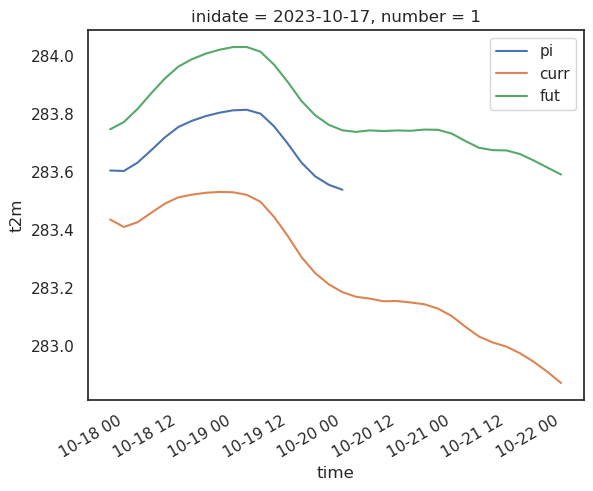

In [33]:
babet_pi.mean(dim=['latitude', 'longitude']).t2m.rolling(time=8).mean().plot(label='pi')
babet_curr.mean(dim=['latitude', 'longitude']).t2m.rolling(time=8).mean().plot(label='curr')
babet_incr.mean(dim=['latitude', 'longitude']).t2m.rolling(time=8).mean().plot(label='fut')
plt.legend()

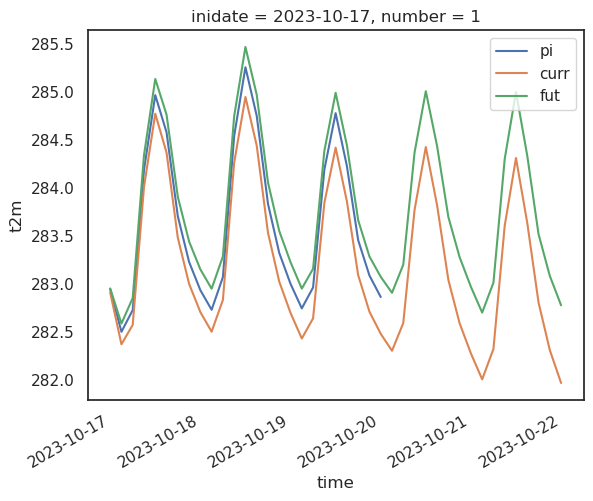

In [41]:
babet_pi.mean(dim=['latitude', 'longitude']).t2m.plot(label='pi')
babet_curr.mean(dim=['latitude', 'longitude']).t2m.plot(label='curr')
babet_incr.mean(dim=['latitude', 'longitude']).t2m.plot(label='fut')

plt.legend()

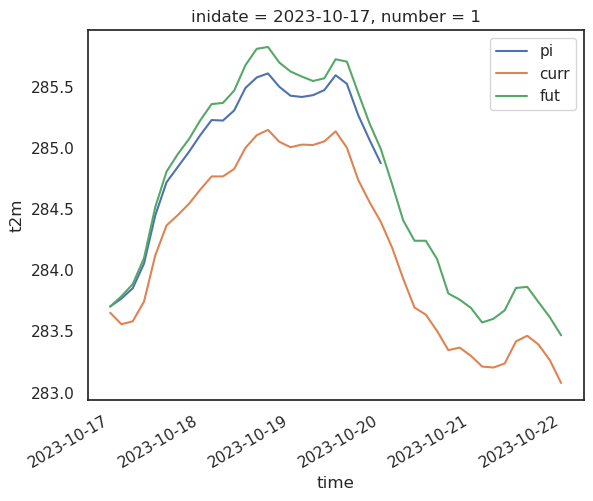

In [40]:
babet_pi.sel(latitude=slice(65,50), longitude=slice(-15, -5)).mean(dim=['latitude', 'longitude']).t2m.plot(label='pi')
babet_curr.sel(latitude=slice(65,50), longitude=slice(-15, -5)).mean(dim=['latitude', 'longitude']).t2m.plot(label='curr')
babet_incr.sel(latitude=slice(65,50), longitude=slice(-15, -5)).mean(dim=['latitude', 'longitude']).t2m.plot(label='fut')

plt.legend()

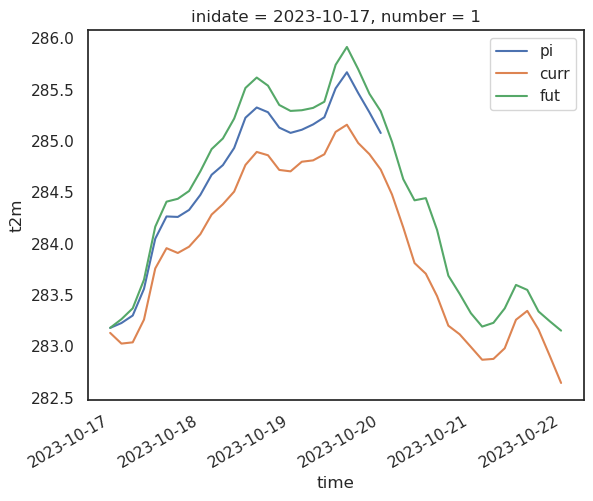

In [39]:
babet_pi.sel(latitude=slice(65,50), longitude=slice(-10, -5)).mean(dim=['latitude', 'longitude']).t2m.plot(label='pi')
babet_curr.sel(latitude=slice(65,50), longitude=slice(-10, -5)).mean(dim=['latitude', 'longitude']).t2m.plot(label='curr')
babet_incr.sel(latitude=slice(65,50), longitude=slice(-10, -5)).mean(dim=['latitude', 'longitude']).t2m.plot(label='fut')

plt.legend()